In [23]:
import importlib
import sys

import numpy as np

# Force reload to avoid stale objects
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
from symbolic_bounds.random_dag_generator import generate_random_partitioned_dag
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


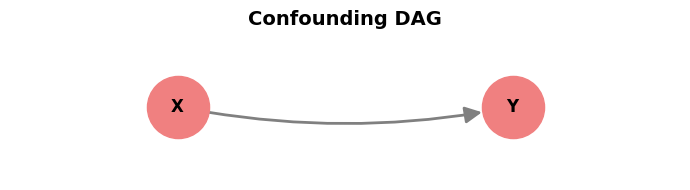

In [9]:
# 1. Generate a confounding DAG
dag = DAG()
X = dag.add_node('X', support={0, 1})
Y = dag.add_node('Y', support={0, 1})
# L0 = dag.add_node('L0', support={0, 1}, partition='L')
dag.add_edge(X, Y)

fig = dag.draw(figsize=(7, 2), title="Confounding DAG", with_labels=True)
plt.show()


In [10]:
dag.generate_all_response_types()
dag.print_response_type_table(X)
dag.print_response_type_table(Y)


Response types for X (no parents):
r_X^1: X = 0
r_X^2: X = 1


Response types for Y (parents: X):
=====

r_Y^1:
X | Y
-----
0 | 0
1 | 0

r_Y^2:
X | Y
-----
0 | 0
1 | 1

r_Y^3:
X | Y
-----
0 | 1
1 | 0

r_Y^4:
X | Y
-----
0 | 1
1 | 1



In [11]:
# 3. Generate Data
generator = DataGenerator(dag, seed=234)
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
p11 = joint.get(frozenset({(X, 1), (Y, 1)}))
p10 = joint.get(frozenset({(X, 1), (Y, 0)}))
generator.print_true_distribution()
print(f'The known tian pearl bounds: [{p11:.4f}, {1-p10:.4f}] for P(Y=1 | do(X=1))')


TRUE RESPONSE TYPE DISTRIBUTION

Node: X
----------------------------------------
  P(R_X = 0) = 0.190930
  P(R_X = 1) = 0.809070
  Total: 1.000000

Node: Y
----------------------------------------
  P(R_Y = [(X=0)→0, (X=1)→0]) = 0.005015
  P(R_Y = [(X=0)→0, (X=1)→1]) = 0.046779
  P(R_Y = [(X=0)→1, (X=1)→0]) = 0.388216
  P(R_Y = [(X=0)→1, (X=1)→1]) = 0.559990
  Total: 1.000000

The known tian pearl bounds: [0.4909, 0.6818] for P(Y=1 | do(X=1))


In [24]:
# 4. Create SCM
scm = SCM(dag, generator)

lp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))

lp.is_minimization = True
# lp.print_decision_variables()
# lp.print_objective()

lb = lp.solve(verbose=False).evaluate_objective(np.array([1]))

lp.is_minimization = False
ub = -lp.solve(verbose=False).evaluate_objective(np.array([1]))
print(f"\nEstimated bounds for P(Y=1 | do(X=1)): [{lb:.6f}, {ub:.6f}]")

true_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"True P(Y=1 | do(X=1)) = {true_prob:.6f}")


Estimated bounds for P(Y=1 | do(X=1)): [0.490918, 0.681848]
True P(Y=1 | do(X=1)) = 0.606769


C:\Users\tmari\AppData\Local\Temp\ipykernel_25624\1614757581.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


<Axes: title={'center': 'Bounds vs True Probability with Experimental Constraints'}, xlabel='parameter'>

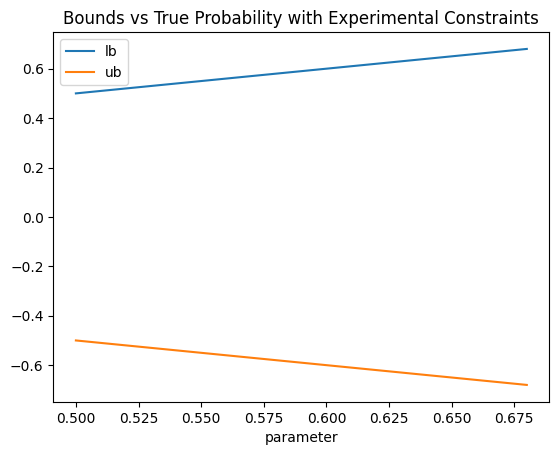

In [40]:
# Test with experimental constraints
lp_exp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
                                  V={Y}, Z={X}, V_values=(1,), Z_values=(1,))

lp_exp.is_minimization = True
result_lb = lp_exp.solve(verbose=False)
lp_exp.is_minimization = False
result_ub = lp_exp.solve(verbose=False)

import pandas as pd
df = pd.DataFrame(columns=['parameter', 'lb','ub', 'w','true_prob'])
for p in range(0, 101):  # Loop from 0 to 100 inclusive
    parameter = p / 100  # Convert to step size of 0.01
    lb = result_lb.evaluate_objective(np.array([parameter]))
    ub = result_ub.evaluate_objective(np.array([parameter]))
    if lb is None or ub is None:
        continue
    df = pd.concat([df, pd.DataFrame([{
        'parameter': parameter,
        'lb': lb,
        'ub': ub,
        'w': ub-lb,
        'true_prob': true_prob
    }])], ignore_index=True)

df.plot(x='parameter', y=['lb', 'ub'], title='Bounds vs True Probability with Experimental Constraints')

In [15]:
# Test with experimental constraints
lp_exp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
                                  V={Y}, Z={X}, V_values=(1,), Z_values=(1,))

print(f"Experiment matrix shape: {lp_exp.experiment_matrix.shape if lp_exp.experiment_matrix is not None else None}")
print(f"Experiment labels: {lp_exp.experiment_labels}")

# Try to solve with a parameter value
true_prob = generator.computeTrueIntervention(Y={Y}, X={X}, Y_values=(1,), X_values=(1,))
print(f"\nTrue P(Y=1 | do(X=1)) = {true_prob:.6f}")

lp_exp.is_minimization = True
try:
    result = lp_exp.solve(verbose=False)
    print(f"\nResult type: {type(result)}")
    print(f"Number of critical regions: {len(result.critical_regions)}")
    
    # Check if we can evaluate at the true probability
    theta = np.array([true_prob]).reshape(-1, 1)
    print(f"Theta shape: {theta.shape}")
    
    # Get the region
    region = result.get_region(theta)
    print(f"Region found: {region is not None}")
    
    if region:
        x_star = region.evaluate(theta)
        print(f"x_star shape: {x_star.shape}")
        print(f"x_star values (first 5): {x_star.flatten()[:5]}")
    
    # Try to evaluate objective
    obj = result.evaluate_objective(theta)
    print(f"Objective value: {obj}")
    
except Exception as e:
    print(f"Error: {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()


Experiment matrix shape: (1, 8)
Experiment labels: ['P(Y=1 | do(X=1))']

True P(Y=1 | do(X=1)) = 0.606769

Result type: <class 'ppopt.solution.Solution'>
Number of critical regions: 16
Theta shape: (1, 1)
Region found: True
x_star shape: (8, 1)
x_star values (first 5): [2.74554253e-16 9.88905192e-03 7.50795852e-02 1.05961124e-01
 4.37719892e-17]
Objective value: 0.606768558451401


In [16]:
# Compare: Without experimental constraints (current working case)
lp_no_exp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))

print("=" * 80)
print("WITHOUT EXPERIMENTAL CONSTRAINTS:")
print("=" * 80)
lp_no_exp.is_minimization = True
result_no_exp = lp_no_exp.solve(verbose=False)
print(f"Result type: {type(result_no_exp)}")
print(f"Number of critical regions: {len(result_no_exp.critical_regions) if hasattr(result_no_exp, 'critical_regions') else 'N/A'}")

# Try to use it the way the existing code does:
try:
    lb = result_no_exp.evaluate_objective(np.array([1]))
    print(f"Lower bound (old way with dummy theta=1): {lb}")
except Exception as e:
    print(f"Error with old way: {e}")


WITHOUT EXPERIMENTAL CONSTRAINTS:
Result type: <class 'ppopt.solution.Solution'>
Number of critical regions: 4
Lower bound (old way with dummy theta=1): 0.49091838259362347


In [17]:
# Test the parametric solution properly
print("\n" + "=" * 80)
print("TESTING PARAMETRIC LP WITH EXPERIMENTAL CONSTRAINTS:")
print("=" * 80)

# Create LP with experimental constraint P(Y=1|do(X=1)) = theta
lp_with_exp = ProgramFactory.write_LP(
    scm, 
    Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
    V={Y}, Z={X}, V_values=(1,), Z_values=(1,)
)

print(f"Experiment matrix shape: {lp_with_exp.experiment_matrix.shape}")
print(f"Experiment labels: {lp_with_exp.experiment_labels}")

# Solve to get parametric solution
lp_with_exp.is_minimization = True
solution = lp_with_exp.solve(verbose=False)

print(f"\nNumber of critical regions: {len(solution.critical_regions)}")
print(f"Solution covers parameter space for theta (experimental result)")

# Test at different experimental values
test_values = [0.4, 0.5, 0.6, 0.7, 0.8]
print(f"\nEvaluating objective at different experimental results:")
print(f"{'theta':<10} {'Objective':<15} {'In Region?'}")
print("-" * 40)
for val in test_values:
    theta_val = np.array([[val]])
    region = solution.get_region(theta_val)
    if region:
        obj = solution.evaluate_objective(theta_val)
        print(f"{val:<10.4f} {obj:<15.6f} Yes")
    else:
        print(f"{val:<10.4f} {'N/A':<15} No")

# Compare with true value
print(f"\nTrue P(Y=1|do(X=1)) = {true_prob:.6f}")
theta_true = np.array([[true_prob]])
obj_at_true = solution.evaluate_objective(theta_true)
print(f"Objective at true experimental value: {obj_at_true:.6f}")
print(f"\nThis represents P(Y=1|do(X=1)) given that we observed")
print(f"P(Y=1|do(X=1)) = {true_prob:.6f} in our experiment!")



TESTING PARAMETRIC LP WITH EXPERIMENTAL CONSTRAINTS:
Experiment matrix shape: (1, 8)
Experiment labels: ['P(Y=1 | do(X=1))']

Number of critical regions: 16
Solution covers parameter space for theta (experimental result)

Evaluating objective at different experimental results:
theta      Objective       In Region?
----------------------------------------
0.4000     N/A             No
0.5000     0.500000        Yes
0.6000     0.600000        Yes
0.7000     N/A             No
0.8000     N/A             No

True P(Y=1|do(X=1)) = 0.606769
Objective at true experimental value: 0.606769

This represents P(Y=1|do(X=1)) given that we observed
P(Y=1|do(X=1)) = 0.606769 in our experiment!


In [18]:
# More interesting test: Compute P(Y=0|do(X=1)) given we know P(Y=1|do(X=1))
print("\n" + "=" * 80)
print("INTERESTING TEST: Compute P(Y=0|do(X=1)) given experimental P(Y=1|do(X=1)):")
print("=" * 80)

# Create LP: objective is P(Y=0|do(X=1)), constraint is P(Y=1|do(X=1)) = theta
lp_complementary = ProgramFactory.write_LP(
    scm,
    Y={Y}, X={X}, Y_values=(0,), X_values=(1,),  # Objective: P(Y=0|do(X=1))
    V={Y}, Z={X}, V_values=(1,), Z_values=(1,)   # Constraint: P(Y=1|do(X=1)) = theta
)

lp_complementary.is_minimization = True
solution_comp = lp_complementary.solve(verbose=False)

print(f"Number of critical regions: {len(solution_comp.critical_regions)}")

# Test at different experimental values
print(f"\nGiven experimental result P(Y=1|do(X=1)) = theta:")
print(f"{'P(Y=1|do(X=1))':<20} {'P(Y=0|do(X=1))':<20} {'Sum':<10}")
print("-" * 50)
for val in [0.5, 0.55, 0.6, 0.65]:
    theta_val = np.array([[val]])
    region = solution_comp.get_region(theta_val)
    if region:
        obj = solution_comp.evaluate_objective(theta_val)
        total = val + obj
        print(f"{val:<20.6f} {obj:<20.6f} {total:.6f}")
    else:
        print(f"{val:<20.6f} {'N/A':<20} N/A")

print("\nNotice: P(Y=0|do(X=1)) + P(Y=1|do(X=1)) = 1.0")
print("This is the complementary probability!")



INTERESTING TEST: Compute P(Y=0|do(X=1)) given experimental P(Y=1|do(X=1)):
Number of critical regions: 16

Given experimental result P(Y=1|do(X=1)) = theta:
P(Y=1|do(X=1))       P(Y=0|do(X=1))       Sum       
--------------------------------------------------
0.500000             0.500000             1.000000
0.550000             0.450000             1.000000
0.600000             0.400000             1.000000
0.650000             0.350000             1.000000

Notice: P(Y=0|do(X=1)) + P(Y=1|do(X=1)) = 1.0
This is the complementary probability!


In [19]:
# Test the shape issue
print("\n" + "=" * 80)
print("TESTING ARRAY SHAPES:")
print("=" * 80)

lp_test = ProgramFactory.write_LP(
    scm, 
    Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
    V={Y}, Z={X}, V_values=(1,), Z_values=(1,)
)

lp_test.is_minimization = True
solution_test = lp_test.solve(verbose=False)

# Test with different shapes
print("\nTrying np.array([0.6]) (1D array):")
try:
    result1 = solution_test.evaluate_objective(np.array([0.6]))
    print(f"  Result: {result1}")
except Exception as e:
    print(f"  Error: {e}")

print("\nTrying np.array([[0.6]]) (2D column vector):")
try:
    result2 = solution_test.evaluate_objective(np.array([[0.6]]))
    print(f"  Result: {result2}")
except Exception as e:
    print(f"  Error: {e}")

print("\nTrying np.array([0.6]).reshape(-1, 1) (explicit reshape):")
try:
    result3 = solution_test.evaluate_objective(np.array([0.6]).reshape(-1, 1))
    print(f"  Result: {result3}")
except Exception as e:
    print(f"  Error: {e}")



TESTING ARRAY SHAPES:

Trying np.array([0.6]) (1D array):
  Result: None

Trying np.array([[0.6]]) (2D column vector):
  Result: 0.5999999999999991

Trying np.array([0.6]).reshape(-1, 1) (explicit reshape):
  Result: 0.5999999999999991


In [20]:
# Compare: without experimental constraints, using 1D array
print("\n" + "=" * 80)
print("WITHOUT EXPERIMENTS (current working case with 1D array):")
print("=" * 80)

lp_no_exp2 = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))
lp_no_exp2.is_minimization = True
solution_no_exp = lp_no_exp2.solve(verbose=False)

print("\nTrying np.array([1]) (1D array - current usage):")
try:
    result = solution_no_exp.evaluate_objective(np.array([1]))
    print(f"  Result: {result}")
    print(f"  Works! This is why current code works without experiments.")
except Exception as e:
    print(f"  Error: {e}")

print("\nTrying np.array([[1]]) (2D column vector):")
try:
    result = solution_no_exp.evaluate_objective(np.array([[1]]))
    print(f"  Result: {result}")
except Exception as e:
    print(f"  Error: {e}")



WITHOUT EXPERIMENTS (current working case with 1D array):

Trying np.array([1]) (1D array - current usage):
  Result: 0.49091838259362347
  Works! This is why current code works without experiments.

Trying np.array([[1]]) (2D column vector):
  Result: 0.49091838259362347


In [22]:
# Test the updated implementation with automatic shape handling
print("\n" + "=" * 80)
print("TESTING UPDATED IMPLEMENTATION:")
print("=" * 80)

# Reload the module to get the updated code
import importlib
import sys
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
import numpy as np

# Recreate the simple DAG
dag = DAG()
X = dag.add_node('X', support={0, 1})
Y = dag.add_node('Y', support={0, 1})
dag.add_edge(X, Y)
dag.generate_all_response_types()

generator = DataGenerator(dag, seed=234)
scm = SCM(dag, generator)

print("\n1. WITHOUT experimental constraints (current working case):")
print("-" * 60)
lp1 = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))
lp1.is_minimization = True
result1 = lp1.solve(verbose=False)

print(f"Type: {type(result1).__name__}")
print(f"Using np.array([1]):          {result1.evaluate_objective(np.array([1])):.6f}")
print(f"Using np.array([[1]]):        {result1.evaluate_objective(np.array([[1]])):.6f}")
print(f"Using scalar 1:               {result1.evaluate_objective(1):.6f}")
print("✓ All work!")

print("\n2. WITH experimental constraints:")
print("-" * 60)
lp2 = ProgramFactory.write_LP(
    scm, 
    Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
    V={Y}, Z={X}, V_values=(1,), Z_values=(1,)
)
lp2.is_minimization = True
result2 = lp2.solve(verbose=False)

true_prob = generator.computeTrueIntervention(Y={Y}, X={X}, Y_values=(1,), X_values=(1,))

print(f"Type: {type(result2).__name__}")
print(f"True P(Y=1|do(X=1)) = {true_prob:.6f}")
print(f"Using np.array([{true_prob:.4f}]):    {result2.evaluate_objective(np.array([true_prob])):.6f}")
print(f"Using np.array([[{true_prob:.4f}]]):  {result2.evaluate_objective(np.array([[true_prob]])):.6f}")
print(f"Using scalar {true_prob:.4f}:         {result2.evaluate_objective(true_prob):.6f}")
print("✓ All work!")

print("\n3. Test bounds computation with feasible values:")
print("-" * 60)
# Use a value we know is feasible
lp3 = ProgramFactory.write_LP(
    scm,
    Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
    V={Y}, Z={X}, V_values=(1,), Z_values=(1,)
)
lp3.is_minimization = True
lb = lp3.solve(verbose=False).evaluate_objective(0.6)

lp3.is_minimization = False  
ub_result = lp3.solve(verbose=False).evaluate_objective(0.6)

print(f"Given P(Y=1|do(X=1)) = 0.6 (from experiment):")
print(f"Bounds on P(Y=1|do(X=1)): [{lb:.6f}, {-ub_result:.6f}]")
print(f"Note: bounds collapse to the experimental value!")
print("✓ Works with scalar input!")



TESTING UPDATED IMPLEMENTATION:

1. WITHOUT experimental constraints (current working case):
------------------------------------------------------------
Type: ParametricSolution
Using np.array([1]):          0.490918
Using np.array([[1]]):        0.490918
Using scalar 1:               0.490918
✓ All work!

2. WITH experimental constraints:
------------------------------------------------------------
Type: ParametricSolution
True P(Y=1|do(X=1)) = 0.606769
Using np.array([0.6068]):    0.606769
Using np.array([[0.6068]]):  0.606769
Using scalar 0.6068:         0.606769
✓ All work!

3. Test bounds computation with feasible values:
------------------------------------------------------------
Given P(Y=1|do(X=1)) = 0.6 (from experiment):
Bounds on P(Y=1|do(X=1)): [0.600000, 0.600000]
Note: bounds collapse to the experimental value!
✓ Works with scalar input!
